<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/DEep_Neural_Net_Gross_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from sklearn import preprocessing 
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#m1
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_all_genes_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.obsm["X_pca"].X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
#m2
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_HVGs_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
#m3
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_no_PC_HVGs_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scanpy as sc

from torch.utils.data import TensorDataset

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# seed = 4321
# np.random.seed(seed) # Set the random seed of numpy for the data split.
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [ ]:
import random

I got everthing :)



In [ ]:
#the real train and test dataset
# train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
# test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

####Set up the model.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.n = X_train.shape[1] #number of rows
        
      self.fc1 = nn.Linear(self.n, int(self.n/2))
      self.fc2 = nn.Linear(int(self.n/2), int(self.n/4))
      #self.fc3 = nn.Linear(int(len(X_train)/4),int(len(X_train)/8))
      self.output = nn.Linear(int(self.n/4), 2)
        
      # this are defining the layers and the hyper paramters that means the 
      # conditions to compare
    
    def forward(self, x):      
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      #x = F.relu(self.fc3(x))
      out = self.output(x)   # the RelU is non linearity that removes all negative values and shouldn't be used right before softmax
      return out

    def print(self):
        return self.fc1
    
# A = NeuralNet()
# A.print()
      # here we are telling the model how to pass the information from on layer to the next
      #in pytorch we do not explain the graph traveral method as this computational graph is automatically defined

In [ ]:
def loss_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

In [ ]:
def train(epoch, model, train_loader, optimizer, device):
    
    # activate the training mode
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    correct = 0
    
    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        target=target.float()

        # reinitialize the gradients to zero
        optimizer.zero_grad()
        
        # forward propagation on the data
        prediction = model(data)
        
        # compute the loss function w.r.t. the targets 
        loss = loss_function(prediction, target)
        
        # execute the backpropagation
        loss.backward()
        
        # execute an optimization step
        optimizer.step()
        
        # accumulate the loss
        total_loss += loss.item()*len(data)
        # we multiply by the length of the data incase the last minibatch is smaller we are 'denormalizing' so that a small batch isn't overweighted
        
        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)
        _, target_classes = torch.max(target, dim=1)

        #print(pred_classes)      
        #print(type(pred_classes))  
        #print(pred_classes.shape)

        #print(prediction.shape)
        correct += int(pred_classes.eq(target_classes).sum().item())
        # print('pred', prediction)
        # print('target', target)
        # print('correct', correct)
        #print(prediction.shape)

    # compute the average loss per epoch
    mean_loss = total_loss/len(train_loader.dataset)
  
    # compute the accuracy
    acc = correct / len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
# Evaluation Procedure
def evaluate(model, eval_loader, device):
    
    # activate the evaluation mode
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
    # we don't need to compute the gradient graph it using too much compuatation
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)
            target=target.float()

            # forward propagation on the data
            prediction = model(data)

            # compute the loss function w.r.t. the targets
            loss = loss_function(prediction, target)           

            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1)
            _, target_classes = torch.max(target, dim=1)

            correct += int(pred_classes.eq(target_classes).sum().item())         
          
    # compute the average loss per epoch
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
def save_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # saving the model parameters
    torch.save(model.state_dict(), filename)
    
    return model

In [ ]:
def load_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))
    
    return model

In [ ]:
import copy

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #initial stabilized split

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# test_lst = []
seed_list = []
dict_list = []
for m in range (10):
  X_test = copy.deepcopy(X_test_global)
  y_test = copy.deepcopy(y_test_global)

  if len(seed_list) < 10:
    seed = random.randint(0, 9999)
    seed_list.append(seed)
    print("seed: ", seed)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #initial stabilized split
    X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    # test_lst.append(X_test)
  else:
    print("seed = ", seed)
    print(seed_list[m])
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #initial stabilized split
    X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    # test_lst.append(X_test)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

#Take some data from test set for validation
#Get the validation dataset splitted
# X_val = X_test.head(499)
# X_test = X_test.tail(1000)
# y_val = y_test.head(499)
# y_test = y_test.tail(1000)
# print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

  # print(type(X_val), type(X_train), type(X_test), type(y_val), type(y_train), type(y_test)

  # Type conversion
  X_val = X_val.astype(np.float64)
  y_val = y_val.astype(np.float64)
  # X_val = X_val.to_numpy()
  # y_val = y_val.to_numpy()

  #Note: SoftMax requires a 2x1 matrix for the label. We turn the above `y_val`, `y_train` and `y_test` numpy array into a matrix.
  y_val = np.stack([y_val, 1-y_val])
  y_val = y_val.transpose()
  #print(y_val)

  y_train = y_train.astype(np.float64)
  y_train = np.stack([y_train, 1-y_train])
  y_train = y_train.transpose()
  #print(y_train)

  y_test = y_test.astype(np.float64)
  y_test = np.stack([y_test, 1-y_test])
  y_test = y_test.transpose()
  #print(y_test)

  # X_train = X_train.to_numpy()
  # X_test = X_test.to_numpy()

  #the real train and test dataset
  train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
  #print('X_test Y test: ', X_test.shape, y_test.shape)
  #print('X train Y train: ', X_train.shape, y_train.shape)
  test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  #SEPARATE CELL 

  # Model definition - we definited above here we initiate a model
  neural_net = NeuralNet()
  neural_net = neural_net.to(device) #We create an instance of NeuralNetwork, and move it to the device, and print its structure.

  # Evaluation mode activation
  neural_net = neural_net.eval()

  # Select the first 5 data points the name of the model is data
  data, target = test_dataset[0:5]

  data = data.to(device)
  target = target.to(device)

  # Forward propagation of the data through the model
  output = neural_net(data)   # equivalent to neural_net.forward(data)
  print("output",output)
  # Convert the logits into probabilities with softmax function
  output_proba = F.softmax(output,dim=1)  # the dimension is to normalize over the outcome, over rows or columns 0 will be incorrect and sum over columns

  # Printing the probability
  print(output_proba)
  
  _, prediction = torch.max(output_proba, dim=1)

  print('Model prediction')
  print(prediction)

  # Printing the real labels
  print("Actual data")
  print(target)

  optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 

  train_batch_size = 32  # number of data in a training batch.
  eval_batch_size = 32   # number of data in an batch.

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
  val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
  test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

  from tqdm import tqdm

  # maximum number of epoch
  numEpochs = 15

  # Saving frequency
  checkpoint_freq = 10

  # Directory for data backup - save the model during training
  path = './'

  # Accumulators of average losses obtained per epoch to visualize training curve
  train_losses = []
  val_losses = []

  # Performance accumulators per epoch
  train_accuracies = []
  val_accuracies = []

  # Model definition
  neural_net = NeuralNet()

  # Load the model on the chosen device
  neural_net = neural_net.to(device)

  # Optimizer definition
  optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
  # optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 

  # Learning loop
  for epoch in tqdm(range(1, numEpochs + 1)):
      
      # train the model with the train dataset
      # inner loop one step 
      train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)   
    
      # evaluate the model with the validation dataset
      val_loss, val_acc = evaluate(neural_net, val_loader, device)       
      
      # Save the losses obtained
      train_losses.append(train_loss)    
      val_losses.append(val_loss)
      
      # Save the performances
      train_accuracies.append(train_acc)    
      val_accuracies.append(val_acc)
      
      # Checkpoint
      if epoch % checkpoint_freq ==0:
          save_model(epoch, neural_net, path)

  # Save the model at the end of the training
  save_model(numEpochs, neural_net, path)
      
  print("\n\n\nOptimization ended.\n")


  # Activate the evaluation mode
  neural_net = neural_net.eval()

  # Select the first 10 data points of the validation set
  data, target = test_dataset[0:10]
  data = data.to(device)

  # Executing the neural network
  output = neural_net(data)   # equivalent to neural_net.forward(data)

  # Transform the output into a probability distribution with a softmax function
  output_proba = F.softmax(output, dim=1)

  # Print the probability
  print(output_proba)    


  # For each example, retrieve the class with the highest probability.
  _, prediction = torch.max(output_proba, dim=1)

  print("Model predictions")
  print(prediction)

  print("Targets")
  print(target)

  valid_loss, valid_acc = evaluate(neural_net, val_loader, device)
  test_loss, test_acc = evaluate(neural_net, test_loader, device)

  #Disctionary append 
  row_dict = {'Seed': seed_list[m], 'DNN validation acc': valid_acc, 'DNN test acc': test_acc}
  dict_list.append(row_dict)

df = pd.DataFrame.from_dict(dict_list)
print(df)


seed:  5825
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.1583,  0.0552],
        [-0.0488, -0.0885],
        [ 0.1020,  0.0919],
        [ 0.0738,  0.1464],
        [ 0.0443,  0.0550]], grad_fn=<AddmmBackward0>)
tensor([[0.5258, 0.4742],
        [0.5099, 0.4901],
        [0.5025, 0.4975],
        [0.4818, 0.5182],
        [0.4973, 0.5027]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 0, 0, 1, 1])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09587   Acc: 14463/15011 (96.349%)


  7%|▋         | 1/15 [00:18<04:22, 18.74s/it]

Eval:  Avg_Loss: 0.05990   Acc: 4918/5004 (98.281%)
Train Epoch: 2   Avg_Loss: 0.02011   Acc: 14935/15011 (99.494%)


 13%|█▎        | 2/15 [00:39<04:16, 19.70s/it]

Eval:  Avg_Loss: 0.07107   Acc: 4915/5004 (98.221%)
Train Epoch: 3   Avg_Loss: 0.00454   Acc: 14991/15011 (99.867%)


 20%|██        | 3/15 [01:05<04:30, 22.55s/it]

Eval:  Avg_Loss: 0.12549   Acc: 4851/5004 (96.942%)
Train Epoch: 4   Avg_Loss: 0.01402   Acc: 14946/15011 (99.567%)


 27%|██▋       | 4/15 [01:32<04:30, 24.58s/it]

Eval:  Avg_Loss: 0.14240   Acc: 4905/5004 (98.022%)
Train Epoch: 5   Avg_Loss: 0.01825   Acc: 14953/15011 (99.614%)


 33%|███▎      | 5/15 [02:01<04:19, 25.94s/it]

Eval:  Avg_Loss: 0.09067   Acc: 4901/5004 (97.942%)
Train Epoch: 6   Avg_Loss: 0.01024   Acc: 14966/15011 (99.700%)


 40%|████      | 6/15 [02:33<04:13, 28.17s/it]

Eval:  Avg_Loss: 0.13297   Acc: 4892/5004 (97.762%)
Train Epoch: 7   Avg_Loss: 0.00188   Acc: 15000/15011 (99.927%)


 47%|████▋     | 7/15 [03:07<04:01, 30.20s/it]

Eval:  Avg_Loss: 0.11998   Acc: 4910/5004 (98.122%)
Train Epoch: 8   Avg_Loss: 0.00028   Acc: 15010/15011 (99.993%)


 53%|█████▎    | 8/15 [03:43<03:43, 31.99s/it]

Eval:  Avg_Loss: 0.12685   Acc: 4913/5004 (98.181%)
Train Epoch: 9   Avg_Loss: 0.00001   Acc: 15011/15011 (100.000%)


 60%|██████    | 9/15 [04:20<03:20, 33.48s/it]

Eval:  Avg_Loss: 0.13589   Acc: 4919/5004 (98.301%)
Train Epoch: 10   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 67%|██████▋   | 10/15 [04:59<02:55, 35.15s/it]

Eval:  Avg_Loss: 0.15118   Acc: 4921/5004 (98.341%)
Train Epoch: 11   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 73%|███████▎  | 11/15 [05:40<02:27, 36.94s/it]

Eval:  Avg_Loss: 0.16495   Acc: 4921/5004 (98.341%)
Train Epoch: 12   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:22<01:55, 38.42s/it]

Eval:  Avg_Loss: 0.17432   Acc: 4921/5004 (98.341%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [07:04<01:19, 39.56s/it]

Eval:  Avg_Loss: 0.18304   Acc: 4920/5004 (98.321%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [07:47<00:40, 40.57s/it]

Eval:  Avg_Loss: 0.19205   Acc: 4920/5004 (98.321%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:30<00:00, 34.06s/it]

Eval:  Avg_Loss: 0.19881   Acc: 4919/5004 (98.301%)



Optimization ended.

tensor([[1.0000e+00, 1.6318e-11],
        [1.0000e+00, 3.9627e-21],
        [3.3003e-18, 1.0000e+00],
        [1.0000e+00, 2.2023e-15],
        [3.6515e-16, 1.0000e+00],
        [1.0516e-27, 1.0000e+00],
        [1.0905e-24, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.3727e-12],
        [1.0000e+00, 6.1657e-43]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.19881   Acc: 4919/5004 (98.301%)
Eval:  Avg_Loss: 0.29940   Acc: 4901/5004 (97.942%)
seed:  9955
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0617,  0.0993],
        [-0.0318,  0.0070],
        [ 0.0415,  0.0119],
        [-0.0060, -0.0482],
        [ 0.0348,  0.0036]], grad_fn=<AddmmBackward0>)
tensor([[0.4906, 0.5094],
        [0.4903, 0.5097],
        [0.5074, 0.4926],
        [0.5105, 0.4895],
        [0.5078, 0.4922]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([1, 1, 0, 0, 0])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09408   Acc: 14527/15011 (96.776%)


  7%|▋         | 1/15 [00:18<04:19, 18.55s/it]

Eval:  Avg_Loss: 0.06234   Acc: 4909/5004 (98.102%)
Train Epoch: 2   Avg_Loss: 0.01314   Acc: 14944/15011 (99.554%)


 13%|█▎        | 2/15 [00:40<04:26, 20.53s/it]

Eval:  Avg_Loss: 0.09585   Acc: 4891/5004 (97.742%)
Train Epoch: 3   Avg_Loss: 0.00816   Acc: 14974/15011 (99.754%)


 20%|██        | 3/15 [01:03<04:22, 21.87s/it]

Eval:  Avg_Loss: 0.10639   Acc: 4886/5004 (97.642%)
Train Epoch: 4   Avg_Loss: 0.01680   Acc: 14970/15011 (99.727%)


 27%|██▋       | 4/15 [01:34<04:37, 25.19s/it]

Eval:  Avg_Loss: 0.11340   Acc: 4890/5004 (97.722%)
Train Epoch: 5   Avg_Loss: 0.01666   Acc: 14944/15011 (99.554%)


 33%|███▎      | 5/15 [02:06<04:38, 27.89s/it]

Eval:  Avg_Loss: 0.13752   Acc: 4901/5004 (97.942%)
Train Epoch: 6   Avg_Loss: 0.00834   Acc: 14973/15011 (99.747%)


 40%|████      | 6/15 [02:39<04:25, 29.51s/it]

Eval:  Avg_Loss: 0.13085   Acc: 4902/5004 (97.962%)
Train Epoch: 7   Avg_Loss: 0.00294   Acc: 15002/15011 (99.940%)


 47%|████▋     | 7/15 [03:17<04:17, 32.15s/it]

Eval:  Avg_Loss: 0.15817   Acc: 4910/5004 (98.122%)
Train Epoch: 8   Avg_Loss: 0.00033   Acc: 15009/15011 (99.987%)


 53%|█████▎    | 8/15 [03:56<04:00, 34.29s/it]

Eval:  Avg_Loss: 0.16774   Acc: 4909/5004 (98.102%)
Train Epoch: 9   Avg_Loss: 0.00003   Acc: 15011/15011 (100.000%)


 60%|██████    | 9/15 [04:36<03:37, 36.23s/it]

Eval:  Avg_Loss: 0.18415   Acc: 4921/5004 (98.341%)
Train Epoch: 10   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 67%|██████▋   | 10/15 [05:18<03:10, 38.01s/it]

Eval:  Avg_Loss: 0.18876   Acc: 4921/5004 (98.341%)
Train Epoch: 11   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 73%|███████▎  | 11/15 [06:00<02:37, 39.37s/it]

Eval:  Avg_Loss: 0.19366   Acc: 4918/5004 (98.281%)
Train Epoch: 12   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:43<02:01, 40.47s/it]

Eval:  Avg_Loss: 0.19823   Acc: 4917/5004 (98.261%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [07:28<01:23, 41.57s/it]

Eval:  Avg_Loss: 0.20244   Acc: 4917/5004 (98.261%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [08:12<00:42, 42.43s/it]

Eval:  Avg_Loss: 0.20669   Acc: 4916/5004 (98.241%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:57<00:00, 35.82s/it]

Eval:  Avg_Loss: 0.21078   Acc: 4915/5004 (98.221%)



Optimization ended.

tensor([[1.0000e+00, 2.5733e-16],
        [1.0000e+00, 3.7548e-26],
        [3.0894e-10, 1.0000e+00],
        [1.0000e+00, 1.5492e-08],
        [2.2795e-07, 1.0000e+00],
        [6.3378e-24, 1.0000e+00],
        [3.7972e-26, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.3367e-09],
        [1.0000e+00, 1.4013e-45]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.21078   Acc: 4915/5004 (98.221%)
Eval:  Avg_Loss: 0.27665   Acc: 4903/5004 (97.982%)
seed:  656
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0928,  0.0678],
        [ 0.1493,  0.0004],
        [ 0.0816, -0.0142],
        [ 0.0161, -0.0729],
        [ 0.1120, -0.0576]], grad_fn=<AddmmBackward0>)
tensor([[0.5062, 0.4938],
        [0.5371, 0.4629],
        [0.5240, 0.4760],
        [0.5222, 0.4778],
        [0.5423, 0.4577]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 0, 0, 0, 0])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.10134   Acc: 14450/15011 (96.263%)


  7%|▋         | 1/15 [00:18<04:23, 18.82s/it]

Eval:  Avg_Loss: 0.05132   Acc: 4902/5004 (97.962%)
Train Epoch: 2   Avg_Loss: 0.01720   Acc: 14928/15011 (99.447%)


 13%|█▎        | 2/15 [00:41<04:37, 21.36s/it]

Eval:  Avg_Loss: 0.05500   Acc: 4919/5004 (98.301%)
Train Epoch: 3   Avg_Loss: 0.00946   Acc: 14957/15011 (99.640%)


 20%|██        | 3/15 [01:09<04:50, 24.25s/it]

Eval:  Avg_Loss: 0.08800   Acc: 4892/5004 (97.762%)
Train Epoch: 4   Avg_Loss: 0.01904   Acc: 14934/15011 (99.487%)


 27%|██▋       | 4/15 [01:38<04:48, 26.21s/it]

Eval:  Avg_Loss: 0.04994   Acc: 4919/5004 (98.301%)
Train Epoch: 5   Avg_Loss: 0.01331   Acc: 14968/15011 (99.714%)


 33%|███▎      | 5/15 [02:08<04:33, 27.38s/it]

Eval:  Avg_Loss: 0.06192   Acc: 4903/5004 (97.982%)
Train Epoch: 6   Avg_Loss: 0.00675   Acc: 14983/15011 (99.813%)


 40%|████      | 6/15 [02:40<04:20, 28.99s/it]

Eval:  Avg_Loss: 0.26772   Acc: 4890/5004 (97.722%)
Train Epoch: 7   Avg_Loss: 0.01399   Acc: 14976/15011 (99.767%)


 47%|████▋     | 7/15 [03:18<04:15, 31.90s/it]

Eval:  Avg_Loss: 0.11327   Acc: 4908/5004 (98.082%)
Train Epoch: 8   Avg_Loss: 0.00619   Acc: 14991/15011 (99.867%)


 53%|█████▎    | 8/15 [03:54<03:53, 33.41s/it]

Eval:  Avg_Loss: 0.10088   Acc: 4914/5004 (98.201%)
Train Epoch: 9   Avg_Loss: 0.00541   Acc: 14995/15011 (99.893%)


 60%|██████    | 9/15 [04:31<03:25, 34.24s/it]

Eval:  Avg_Loss: 0.18468   Acc: 4887/5004 (97.662%)
Train Epoch: 10   Avg_Loss: 0.03037   Acc: 14946/15011 (99.567%)


 67%|██████▋   | 10/15 [05:07<02:53, 34.79s/it]

Eval:  Avg_Loss: 0.11658   Acc: 4916/5004 (98.241%)
Train Epoch: 11   Avg_Loss: 0.01292   Acc: 14984/15011 (99.820%)


 73%|███████▎  | 11/15 [05:44<02:22, 35.53s/it]

Eval:  Avg_Loss: 0.11537   Acc: 4908/5004 (98.082%)
Train Epoch: 12   Avg_Loss: 0.00142   Acc: 15005/15011 (99.960%)


 80%|████████  | 12/15 [06:21<01:47, 35.95s/it]

Eval:  Avg_Loss: 0.14867   Acc: 4919/5004 (98.301%)
Train Epoch: 13   Avg_Loss: 0.02824   Acc: 14978/15011 (99.780%)


 87%|████████▋ | 13/15 [07:00<01:13, 36.94s/it]

Eval:  Avg_Loss: 0.23140   Acc: 4912/5004 (98.161%)
Train Epoch: 14   Avg_Loss: 0.00473   Acc: 14993/15011 (99.880%)


 93%|█████████▎| 14/15 [07:40<00:37, 37.89s/it]

Eval:  Avg_Loss: 0.21631   Acc: 4922/5004 (98.361%)
Train Epoch: 15   Avg_Loss: 0.00038   Acc: 15009/15011 (99.987%)


100%|██████████| 15/15 [08:19<00:00, 33.32s/it]

Eval:  Avg_Loss: 0.25034   Acc: 4916/5004 (98.241%)



Optimization ended.

tensor([[1.0000e+00, 7.1565e-17],
        [1.0000e+00, 4.9869e-36],
        [3.3888e-19, 1.0000e+00],
        [1.0000e+00, 1.6678e-22],
        [5.8445e-12, 1.0000e+00],
        [2.9069e-40, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.9879e-18],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.25034   Acc: 4916/5004 (98.241%)
Eval:  Avg_Loss: 0.46736   Acc: 4892/5004 (97.762%)
seed:  9564
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0631, -0.0429],
        [ 0.0381, -0.0518],
        [ 0.0476,  0.0221],
        [ 0.0627, -0.1216],
        [-0.0539,  0.0107]], grad_fn=<AddmmBackward0>)
tensor([[0.5265, 0.4735],
        [0.5225, 0.4775],
        [0.5064, 0.4936],
        [0.5459, 0.4541],
        [0.4839, 0.5161]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 0, 0, 0, 1])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09625   Acc: 14465/15011 (96.363%)


  7%|▋         | 1/15 [00:19<04:33, 19.56s/it]

Eval:  Avg_Loss: 0.06102   Acc: 4902/5004 (97.962%)
Train Epoch: 2   Avg_Loss: 0.01633   Acc: 14928/15011 (99.447%)


 13%|█▎        | 2/15 [00:41<04:32, 20.94s/it]

Eval:  Avg_Loss: 0.09210   Acc: 4885/5004 (97.622%)
Train Epoch: 3   Avg_Loss: 0.01065   Acc: 14962/15011 (99.674%)


 20%|██        | 3/15 [01:07<04:41, 23.45s/it]

Eval:  Avg_Loss: 0.09935   Acc: 4913/5004 (98.181%)
Train Epoch: 4   Avg_Loss: 0.00855   Acc: 14967/15011 (99.707%)


 27%|██▋       | 4/15 [01:35<04:36, 25.10s/it]

Eval:  Avg_Loss: 0.15614   Acc: 4874/5004 (97.402%)
Train Epoch: 5   Avg_Loss: 0.00759   Acc: 14980/15011 (99.793%)


 33%|███▎      | 5/15 [02:04<04:25, 26.51s/it]

Eval:  Avg_Loss: 0.13309   Acc: 4893/5004 (97.782%)
Train Epoch: 6   Avg_Loss: 0.01351   Acc: 14970/15011 (99.727%)


 40%|████      | 6/15 [02:37<04:17, 28.59s/it]

Eval:  Avg_Loss: 0.15008   Acc: 4880/5004 (97.522%)
Train Epoch: 7   Avg_Loss: 0.01195   Acc: 14979/15011 (99.787%)


 47%|████▋     | 7/15 [03:09<03:59, 29.90s/it]

Eval:  Avg_Loss: 0.28605   Acc: 4899/5004 (97.902%)
Train Epoch: 8   Avg_Loss: 0.00799   Acc: 14982/15011 (99.807%)


 53%|█████▎    | 8/15 [03:50<03:53, 33.43s/it]

Eval:  Avg_Loss: 0.16563   Acc: 4901/5004 (97.942%)
Train Epoch: 9   Avg_Loss: 0.00557   Acc: 14990/15011 (99.860%)


 60%|██████    | 9/15 [04:32<03:35, 35.98s/it]

Eval:  Avg_Loss: 0.14147   Acc: 4913/5004 (98.181%)
Train Epoch: 10   Avg_Loss: 0.02475   Acc: 14976/15011 (99.767%)


 67%|██████▋   | 10/15 [05:12<03:06, 37.24s/it]

Eval:  Avg_Loss: 0.30695   Acc: 4887/5004 (97.662%)
Train Epoch: 11   Avg_Loss: 0.02265   Acc: 14944/15011 (99.554%)


 73%|███████▎  | 11/15 [05:52<02:32, 38.06s/it]

Eval:  Avg_Loss: 0.21388   Acc: 4899/5004 (97.902%)
Train Epoch: 12   Avg_Loss: 0.00953   Acc: 14990/15011 (99.860%)


 80%|████████  | 12/15 [06:33<01:57, 39.06s/it]

Eval:  Avg_Loss: 0.14941   Acc: 4900/5004 (97.922%)
Train Epoch: 13   Avg_Loss: 0.01643   Acc: 14991/15011 (99.867%)


 87%|████████▋ | 13/15 [07:11<01:17, 38.78s/it]

Eval:  Avg_Loss: 0.42286   Acc: 4886/5004 (97.642%)
Train Epoch: 14   Avg_Loss: 0.00890   Acc: 14995/15011 (99.893%)


 93%|█████████▎| 14/15 [07:54<00:39, 39.85s/it]

Eval:  Avg_Loss: 0.23541   Acc: 4919/5004 (98.301%)
Train Epoch: 15   Avg_Loss: 0.00169   Acc: 15004/15011 (99.953%)


100%|██████████| 15/15 [08:36<00:00, 34.41s/it]

Eval:  Avg_Loss: 0.35664   Acc: 4908/5004 (98.082%)



Optimization ended.

tensor([[1.0000e+00, 2.1167e-28],
        [1.0000e+00, 0.0000e+00],
        [1.8712e-09, 1.0000e+00],
        [1.0000e+00, 1.5852e-28],
        [1.6629e-10, 1.0000e+00],
        [3.2597e-28, 1.0000e+00],
        [7.4764e-29, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 5.7880e-36],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.35664   Acc: 4908/5004 (98.082%)
Eval:  Avg_Loss: 0.50140   Acc: 4895/5004 (97.822%)
seed:  5739
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0959, -0.0029],
        [ 0.0895,  0.0740],
        [-0.0369,  0.0807],
        [ 0.0207, -0.0841],
        [ 0.0662,  0.0269]], grad_fn=<AddmmBackward0>)
tensor([[0.5247, 0.4753],
        [0.5039, 0.4961],
        [0.4706, 0.5294],
        [0.5262, 0.4738],
        [0.5098, 0.4902]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 0, 1, 0, 0])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09638   Acc: 14505/15011 (96.629%)


  7%|▋         | 1/15 [00:20<04:47, 20.51s/it]

Eval:  Avg_Loss: 0.05276   Acc: 4917/5004 (98.261%)
Train Epoch: 2   Avg_Loss: 0.02223   Acc: 14922/15011 (99.407%)


 13%|█▎        | 2/15 [00:43<04:46, 22.06s/it]

Eval:  Avg_Loss: 0.08996   Acc: 4882/5004 (97.562%)
Train Epoch: 3   Avg_Loss: 0.01352   Acc: 14962/15011 (99.674%)


 20%|██        | 3/15 [01:10<04:50, 24.24s/it]

Eval:  Avg_Loss: 0.07560   Acc: 4900/5004 (97.922%)
Train Epoch: 4   Avg_Loss: 0.01756   Acc: 14976/15011 (99.767%)


 27%|██▋       | 4/15 [01:39<04:49, 26.29s/it]

Eval:  Avg_Loss: 0.08732   Acc: 4906/5004 (98.042%)
Train Epoch: 5   Avg_Loss: 0.00673   Acc: 14981/15011 (99.800%)


 33%|███▎      | 5/15 [02:09<04:35, 27.56s/it]

Eval:  Avg_Loss: 0.10962   Acc: 4914/5004 (98.201%)
Train Epoch: 6   Avg_Loss: 0.00631   Acc: 14992/15011 (99.873%)


 40%|████      | 6/15 [02:46<04:35, 30.59s/it]

Eval:  Avg_Loss: 0.09086   Acc: 4928/5004 (98.481%)
Train Epoch: 7   Avg_Loss: 0.00356   Acc: 14993/15011 (99.880%)


 47%|████▋     | 7/15 [03:22<04:18, 32.30s/it]

Eval:  Avg_Loss: 0.11512   Acc: 4910/5004 (98.122%)
Train Epoch: 8   Avg_Loss: 0.00277   Acc: 14997/15011 (99.907%)


 53%|█████▎    | 8/15 [04:00<03:59, 34.15s/it]

Eval:  Avg_Loss: 0.11895   Acc: 4927/5004 (98.461%)
Train Epoch: 9   Avg_Loss: 0.01025   Acc: 14982/15011 (99.807%)


 60%|██████    | 9/15 [04:38<03:31, 35.33s/it]

Eval:  Avg_Loss: 0.40503   Acc: 4886/5004 (97.642%)
Train Epoch: 10   Avg_Loss: 0.02669   Acc: 14938/15011 (99.514%)


 67%|██████▋   | 10/15 [05:12<02:55, 35.09s/it]

Eval:  Avg_Loss: 0.20463   Acc: 4906/5004 (98.042%)
Train Epoch: 11   Avg_Loss: 0.04391   Acc: 14950/15011 (99.594%)


 73%|███████▎  | 11/15 [05:50<02:23, 35.85s/it]

Eval:  Avg_Loss: 0.21288   Acc: 4920/5004 (98.321%)
Train Epoch: 12   Avg_Loss: 0.00667   Acc: 14990/15011 (99.860%)


 80%|████████  | 12/15 [06:28<01:50, 36.72s/it]

Eval:  Avg_Loss: 0.18926   Acc: 4920/5004 (98.321%)
Train Epoch: 13   Avg_Loss: 0.00755   Acc: 14990/15011 (99.860%)


 87%|████████▋ | 13/15 [07:08<01:15, 37.60s/it]

Eval:  Avg_Loss: 0.32657   Acc: 4917/5004 (98.261%)
Train Epoch: 14   Avg_Loss: 0.05025   Acc: 14966/15011 (99.700%)


 93%|█████████▎| 14/15 [07:44<00:37, 37.24s/it]

Eval:  Avg_Loss: 0.47494   Acc: 4885/5004 (97.622%)
Train Epoch: 15   Avg_Loss: 0.01240   Acc: 14986/15011 (99.833%)


100%|██████████| 15/15 [08:23<00:00, 33.57s/it]

Eval:  Avg_Loss: 0.21326   Acc: 4929/5004 (98.501%)



Optimization ended.

tensor([[1.0000e+00, 1.1971e-19],
        [1.0000e+00, 0.0000e+00],
        [8.8008e-35, 1.0000e+00],
        [1.0000e+00, 4.1693e-20],
        [4.3541e-32, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [6.4238e-28, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.2891e-20],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.21326   Acc: 4929/5004 (98.501%)
Eval:  Avg_Loss: 0.45441   Acc: 4895/5004 (97.822%)
seed:  8412
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[-0.0217,  0.0945],
        [-0.0920,  0.1582],
        [-0.0888,  0.0818],
        [-0.0533, -0.0288],
        [-0.0346,  0.0167]], grad_fn=<AddmmBackward0>)
tensor([[0.4710, 0.5290],
        [0.4378, 0.5622],
        [0.4574, 0.5426],
        [0.4939, 0.5061],
        [0.4872, 0.5128]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([1, 1, 1, 1, 1])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09267   Acc: 14509/15011 (96.656%)


  7%|▋         | 1/15 [00:19<04:37, 19.82s/it]

Eval:  Avg_Loss: 0.05856   Acc: 4905/5004 (98.022%)
Train Epoch: 2   Avg_Loss: 0.01899   Acc: 14915/15011 (99.360%)


 13%|█▎        | 2/15 [00:40<04:23, 20.27s/it]

Eval:  Avg_Loss: 0.06779   Acc: 4909/5004 (98.102%)
Train Epoch: 3   Avg_Loss: 0.00774   Acc: 14979/15011 (99.787%)


 20%|██        | 3/15 [01:06<04:35, 22.92s/it]

Eval:  Avg_Loss: 0.14444   Acc: 4888/5004 (97.682%)
Train Epoch: 4   Avg_Loss: 0.01763   Acc: 14940/15011 (99.527%)


 27%|██▋       | 4/15 [01:32<04:26, 24.22s/it]

Eval:  Avg_Loss: 0.11715   Acc: 4899/5004 (97.902%)
Train Epoch: 5   Avg_Loss: 0.00999   Acc: 14970/15011 (99.727%)


 33%|███▎      | 5/15 [02:04<04:28, 26.89s/it]

Eval:  Avg_Loss: 0.13935   Acc: 4872/5004 (97.362%)
Train Epoch: 6   Avg_Loss: 0.01445   Acc: 14950/15011 (99.594%)


 40%|████      | 6/15 [02:39<04:26, 29.60s/it]

Eval:  Avg_Loss: 0.13906   Acc: 4891/5004 (97.742%)
Train Epoch: 7   Avg_Loss: 0.02501   Acc: 14964/15011 (99.687%)


 47%|████▋     | 7/15 [03:15<04:15, 31.90s/it]

Eval:  Avg_Loss: 0.13377   Acc: 4916/5004 (98.241%)
Train Epoch: 8   Avg_Loss: 0.00294   Acc: 14989/15011 (99.853%)


 53%|█████▎    | 8/15 [03:53<03:55, 33.65s/it]

Eval:  Avg_Loss: 0.16454   Acc: 4913/5004 (98.181%)
Train Epoch: 9   Avg_Loss: 0.00042   Acc: 15009/15011 (99.987%)


 60%|██████    | 9/15 [04:33<03:33, 35.63s/it]

Eval:  Avg_Loss: 0.18913   Acc: 4909/5004 (98.102%)
Train Epoch: 10   Avg_Loss: 0.00001   Acc: 15011/15011 (100.000%)


 67%|██████▋   | 10/15 [05:15<03:08, 37.64s/it]

Eval:  Avg_Loss: 0.20156   Acc: 4910/5004 (98.122%)
Train Epoch: 11   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 73%|███████▎  | 11/15 [05:58<02:36, 39.24s/it]

Eval:  Avg_Loss: 0.20729   Acc: 4911/5004 (98.141%)
Train Epoch: 12   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:41<02:01, 40.47s/it]

Eval:  Avg_Loss: 0.21240   Acc: 4910/5004 (98.122%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [07:26<01:23, 41.73s/it]

Eval:  Avg_Loss: 0.21734   Acc: 4910/5004 (98.122%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [08:09<00:42, 42.16s/it]

Eval:  Avg_Loss: 0.22254   Acc: 4911/5004 (98.141%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:54<00:00, 35.61s/it]

Eval:  Avg_Loss: 0.23204   Acc: 4913/5004 (98.181%)



Optimization ended.

tensor([[1.0000e+00, 1.2312e-14],
        [1.0000e+00, 2.7727e-41],
        [4.3910e-17, 1.0000e+00],
        [1.0000e+00, 2.7057e-16],
        [1.5233e-10, 1.0000e+00],
        [5.7612e-23, 1.0000e+00],
        [8.3846e-22, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.5271e-08],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.23204   Acc: 4913/5004 (98.181%)
Eval:  Avg_Loss: 0.31655   Acc: 4902/5004 (97.962%)
seed:  5891
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[-0.0014, -0.0069],
        [-0.0378,  0.0068],
        [ 0.0414, -0.0160],
        [-0.0273, -0.0162],
        [ 0.0566, -0.0652]], grad_fn=<AddmmBackward0>)
tensor([[0.5014, 0.4986],
        [0.4889, 0.5111],
        [0.5144, 0.4856],
        [0.4972, 0.5028],
        [0.5304, 0.4696]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 1, 0, 1, 0])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09659   Acc: 14493/15011 (96.549%)


  7%|▋         | 1/15 [00:19<04:32, 19.47s/it]

Eval:  Avg_Loss: 0.05151   Acc: 4915/5004 (98.221%)
Train Epoch: 2   Avg_Loss: 0.01763   Acc: 14939/15011 (99.520%)


 13%|█▎        | 2/15 [00:44<04:54, 22.67s/it]

Eval:  Avg_Loss: 0.08875   Acc: 4889/5004 (97.702%)
Train Epoch: 3   Avg_Loss: 0.00635   Acc: 14979/15011 (99.787%)


 20%|██        | 3/15 [01:14<05:10, 25.91s/it]

Eval:  Avg_Loss: 0.07039   Acc: 4917/5004 (98.261%)
Train Epoch: 4   Avg_Loss: 0.00812   Acc: 14979/15011 (99.787%)


 27%|██▋       | 4/15 [01:42<04:55, 26.83s/it]

Eval:  Avg_Loss: 0.07913   Acc: 4902/5004 (97.962%)
Train Epoch: 5   Avg_Loss: 0.01019   Acc: 14967/15011 (99.707%)


 33%|███▎      | 5/15 [02:09<04:29, 26.92s/it]

Eval:  Avg_Loss: 0.09571   Acc: 4907/5004 (98.062%)
Train Epoch: 6   Avg_Loss: 0.03547   Acc: 14926/15011 (99.434%)


 40%|████      | 6/15 [02:45<04:30, 30.05s/it]

Eval:  Avg_Loss: 0.08784   Acc: 4892/5004 (97.762%)
Train Epoch: 7   Avg_Loss: 0.00662   Acc: 14982/15011 (99.807%)


 47%|████▋     | 7/15 [03:17<04:05, 30.74s/it]

Eval:  Avg_Loss: 0.09697   Acc: 4912/5004 (98.161%)
Train Epoch: 8   Avg_Loss: 0.00183   Acc: 15002/15011 (99.940%)


 53%|█████▎    | 8/15 [03:54<03:48, 32.67s/it]

Eval:  Avg_Loss: 0.14319   Acc: 4910/5004 (98.122%)
Train Epoch: 9   Avg_Loss: 0.00012   Acc: 15011/15011 (100.000%)


 60%|██████    | 9/15 [04:34<03:29, 34.94s/it]

Eval:  Avg_Loss: 0.16303   Acc: 4907/5004 (98.062%)
Train Epoch: 10   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 67%|██████▋   | 10/15 [05:17<03:06, 37.39s/it]

Eval:  Avg_Loss: 0.16091   Acc: 4909/5004 (98.102%)
Train Epoch: 11   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 73%|███████▎  | 11/15 [06:00<02:36, 39.11s/it]

Eval:  Avg_Loss: 0.16145   Acc: 4908/5004 (98.082%)
Train Epoch: 12   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:43<02:01, 40.41s/it]

Eval:  Avg_Loss: 0.16218   Acc: 4907/5004 (98.062%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [07:28<01:23, 41.71s/it]

Eval:  Avg_Loss: 0.16318   Acc: 4907/5004 (98.062%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [08:12<00:42, 42.36s/it]

Eval:  Avg_Loss: 0.16434   Acc: 4907/5004 (98.062%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:56<00:00, 35.77s/it]

Eval:  Avg_Loss: 0.16559   Acc: 4907/5004 (98.062%)



Optimization ended.

tensor([[1.0000e+00, 6.5868e-13],
        [1.0000e+00, 1.7182e-22],
        [2.9783e-12, 1.0000e+00],
        [1.0000e+00, 1.5056e-17],
        [6.5716e-19, 1.0000e+00],
        [1.3437e-22, 1.0000e+00],
        [4.1161e-25, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 9.7000e-20],
        [1.0000e+00, 7.0065e-44]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.16559   Acc: 4907/5004 (98.062%)
Eval:  Avg_Loss: 0.25129   Acc: 4916/5004 (98.241%)
seed:  521
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0751,  0.0310],
        [ 0.1375,  0.1006],
        [ 0.0837,  0.0105],
        [ 0.0749,  0.0684],
        [ 0.0605, -0.0119]], grad_fn=<AddmmBackward0>)
tensor([[0.5110, 0.4890],
        [0.5092, 0.4908],
        [0.5183, 0.4817],
        [0.5016, 0.4984],
        [0.5181, 0.4819]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 0, 0, 0, 0])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09862   Acc: 14469/15011 (96.389%)


  7%|▋         | 1/15 [00:19<04:34, 19.64s/it]

Eval:  Avg_Loss: 0.04955   Acc: 4903/5004 (97.982%)
Train Epoch: 2   Avg_Loss: 0.01560   Acc: 14943/15011 (99.547%)


 13%|█▎        | 2/15 [00:41<04:32, 20.97s/it]

Eval:  Avg_Loss: 0.06720   Acc: 4902/5004 (97.962%)
Train Epoch: 3   Avg_Loss: 0.02328   Acc: 14912/15011 (99.340%)


 20%|██        | 3/15 [01:07<04:37, 23.10s/it]

Eval:  Avg_Loss: 0.09307   Acc: 4902/5004 (97.962%)
Train Epoch: 4   Avg_Loss: 0.00581   Acc: 14982/15011 (99.807%)


 27%|██▋       | 4/15 [01:36<04:41, 25.58s/it]

Eval:  Avg_Loss: 0.08931   Acc: 4904/5004 (98.002%)
Train Epoch: 5   Avg_Loss: 0.00130   Acc: 15002/15011 (99.940%)


 33%|███▎      | 5/15 [02:06<04:30, 27.08s/it]

Eval:  Avg_Loss: 0.10506   Acc: 4912/5004 (98.161%)
Train Epoch: 6   Avg_Loss: 0.00009   Acc: 15011/15011 (100.000%)


 40%|████      | 6/15 [02:35<04:11, 27.93s/it]

Eval:  Avg_Loss: 0.11408   Acc: 4913/5004 (98.181%)
Train Epoch: 7   Avg_Loss: 0.00001   Acc: 15011/15011 (100.000%)


 47%|████▋     | 7/15 [03:05<03:48, 28.51s/it]

Eval:  Avg_Loss: 0.11659   Acc: 4913/5004 (98.181%)
Train Epoch: 8   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 53%|█████▎    | 8/15 [03:35<03:22, 28.99s/it]

Eval:  Avg_Loss: 0.12408   Acc: 4913/5004 (98.181%)
Train Epoch: 9   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 60%|██████    | 9/15 [04:08<03:01, 30.33s/it]

Eval:  Avg_Loss: 0.14736   Acc: 4914/5004 (98.201%)
Train Epoch: 10   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 67%|██████▋   | 10/15 [04:46<02:42, 32.54s/it]

Eval:  Avg_Loss: 0.16055   Acc: 4909/5004 (98.102%)
Train Epoch: 11   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 73%|███████▎  | 11/15 [05:27<02:21, 35.30s/it]

Eval:  Avg_Loss: 0.17321   Acc: 4911/5004 (98.141%)
Train Epoch: 12   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:12<01:54, 38.27s/it]

Eval:  Avg_Loss: 0.18417   Acc: 4911/5004 (98.141%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [06:58<01:20, 40.42s/it]

Eval:  Avg_Loss: 0.19234   Acc: 4909/5004 (98.102%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [07:44<00:42, 42.02s/it]

Eval:  Avg_Loss: 0.19923   Acc: 4906/5004 (98.042%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:31<00:00, 34.09s/it]

Eval:  Avg_Loss: 0.20607   Acc: 4907/5004 (98.062%)



Optimization ended.

tensor([[1.0000e+00, 1.0451e-07],
        [1.0000e+00, 6.0304e-23],
        [5.2073e-12, 1.0000e+00],
        [1.0000e+00, 1.0962e-16],
        [6.7733e-10, 1.0000e+00],
        [5.7828e-30, 1.0000e+00],
        [1.1255e-22, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.6621e-14],
        [1.0000e+00, 4.4557e-30]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.20607   Acc: 4907/5004 (98.062%)
Eval:  Avg_Loss: 0.30069   Acc: 4911/5004 (98.141%)
seed:  1791
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[-0.1317,  0.0340],
        [-0.0920,  0.1375],
        [-0.1751, -0.0002],
        [-0.1447,  0.0300],
        [-0.1434, -0.0024]], grad_fn=<AddmmBackward0>)
tensor([[0.4587, 0.5413],
        [0.4429, 0.5571],
        [0.4564, 0.5436],
        [0.4564, 0.5436],
        [0.4648, 0.5352]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([1, 1, 1, 1, 1])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09126   Acc: 14499/15011 (96.589%)


  7%|▋         | 1/15 [00:19<04:26, 19.04s/it]

Eval:  Avg_Loss: 0.06245   Acc: 4892/5004 (97.762%)
Train Epoch: 2   Avg_Loss: 0.01816   Acc: 14935/15011 (99.494%)


 13%|█▎        | 2/15 [00:44<04:59, 23.01s/it]

Eval:  Avg_Loss: 0.07946   Acc: 4898/5004 (97.882%)
Train Epoch: 3   Avg_Loss: 0.00907   Acc: 14970/15011 (99.727%)


 20%|██        | 3/15 [01:12<05:03, 25.29s/it]

Eval:  Avg_Loss: 0.13241   Acc: 4891/5004 (97.742%)
Train Epoch: 4   Avg_Loss: 0.00659   Acc: 14980/15011 (99.793%)


 27%|██▋       | 4/15 [01:42<04:57, 27.04s/it]

Eval:  Avg_Loss: 0.12339   Acc: 4900/5004 (97.922%)
Train Epoch: 5   Avg_Loss: 0.00794   Acc: 14970/15011 (99.727%)


 33%|███▎      | 5/15 [02:13<04:43, 28.39s/it]

Eval:  Avg_Loss: 0.10479   Acc: 4906/5004 (98.042%)
Train Epoch: 6   Avg_Loss: 0.01215   Acc: 14971/15011 (99.734%)


 40%|████      | 6/15 [02:46<04:30, 30.08s/it]

Eval:  Avg_Loss: 0.15756   Acc: 4889/5004 (97.702%)
Train Epoch: 7   Avg_Loss: 0.01046   Acc: 14967/15011 (99.707%)


 47%|████▋     | 7/15 [03:22<04:16, 32.06s/it]

Eval:  Avg_Loss: 0.10420   Acc: 4905/5004 (98.022%)
Train Epoch: 8   Avg_Loss: 0.00682   Acc: 14992/15011 (99.873%)


 53%|█████▎    | 8/15 [04:00<03:57, 33.88s/it]

Eval:  Avg_Loss: 0.24804   Acc: 4896/5004 (97.842%)
Train Epoch: 9   Avg_Loss: 0.01689   Acc: 14969/15011 (99.720%)


 60%|██████    | 9/15 [04:38<03:31, 35.20s/it]

Eval:  Avg_Loss: 0.21063   Acc: 4895/5004 (97.822%)
Train Epoch: 10   Avg_Loss: 0.00191   Acc: 15005/15011 (99.960%)


 67%|██████▋   | 10/15 [05:17<03:01, 36.24s/it]

Eval:  Avg_Loss: 0.20139   Acc: 4907/5004 (98.062%)
Train Epoch: 11   Avg_Loss: 0.00103   Acc: 15005/15011 (99.960%)


 73%|███████▎  | 11/15 [05:57<02:29, 37.39s/it]

Eval:  Avg_Loss: 0.23011   Acc: 4912/5004 (98.161%)
Train Epoch: 12   Avg_Loss: 0.00003   Acc: 15011/15011 (100.000%)


 80%|████████  | 12/15 [06:39<01:56, 38.84s/it]

Eval:  Avg_Loss: 0.24493   Acc: 4914/5004 (98.201%)
Train Epoch: 13   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 87%|████████▋ | 13/15 [07:22<01:20, 40.16s/it]

Eval:  Avg_Loss: 0.25092   Acc: 4914/5004 (98.201%)
Train Epoch: 14   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


 93%|█████████▎| 14/15 [08:07<00:41, 41.46s/it]

Eval:  Avg_Loss: 0.25938   Acc: 4914/5004 (98.201%)
Train Epoch: 15   Avg_Loss: 0.00000   Acc: 15011/15011 (100.000%)


100%|██████████| 15/15 [08:50<00:00, 35.35s/it]

Eval:  Avg_Loss: 0.26895   Acc: 4912/5004 (98.161%)



Optimization ended.

tensor([[1.0000e+00, 3.7418e-18],
        [1.0000e+00, 0.0000e+00],
        [8.7176e-08, 1.0000e+00],
        [1.0000e+00, 2.2540e-15],
        [1.8008e-11, 1.0000e+00],
        [4.1876e-32, 1.0000e+00],
        [1.9137e-23, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.4546e-07],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.26895   Acc: 4912/5004 (98.161%)
Eval:  Avg_Loss: 0.33118   Acc: 4905/5004 (98.022%)
seed:  3550
(15011, 2500) (5004, 2500) (15011,) (5004,)
output tensor([[ 0.0994,  0.0238],
        [ 0.0047,  0.0159],
        [-0.0854,  0.0480],
        [-0.0502,  0.1097],
        [-0.0772, -0.0104]], grad_fn=<AddmmBackward0>)
tensor([[0.5189, 0.4811],
        [0.4972, 0.5028],
        [0.4667, 0.5333],
        [0.4601, 0.5399],
        [0.4833, 0.5167]], grad_fn=<SoftmaxBackward0>)
Model prediction
tensor([0, 1, 1, 1, 1])
Actual data
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]])


  0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1   Avg_Loss: 0.09304   Acc: 14487/15011 (96.509%)


  7%|▋         | 1/15 [00:18<04:16, 18.32s/it]

Eval:  Avg_Loss: 0.05630   Acc: 4917/5004 (98.261%)
Train Epoch: 2   Avg_Loss: 0.01300   Acc: 14954/15011 (99.620%)


 13%|█▎        | 2/15 [00:39<04:17, 19.85s/it]

Eval:  Avg_Loss: 0.07268   Acc: 4894/5004 (97.802%)
Train Epoch: 3   Avg_Loss: 0.01122   Acc: 14965/15011 (99.694%)


 20%|██        | 3/15 [01:06<04:40, 23.37s/it]

Eval:  Avg_Loss: 0.07349   Acc: 4912/5004 (98.161%)
Train Epoch: 4   Avg_Loss: 0.01879   Acc: 14937/15011 (99.507%)


 27%|██▋       | 4/15 [01:35<04:41, 25.63s/it]

Eval:  Avg_Loss: 0.11357   Acc: 4868/5004 (97.282%)
Train Epoch: 5   Avg_Loss: 0.02049   Acc: 14933/15011 (99.480%)


 33%|███▎      | 5/15 [02:07<04:38, 27.84s/it]

Eval:  Avg_Loss: 0.11534   Acc: 4901/5004 (97.942%)
Train Epoch: 6   Avg_Loss: 0.00148   Acc: 15005/15011 (99.960%)


 40%|████      | 6/15 [02:44<04:38, 30.90s/it]

Eval:  Avg_Loss: 0.15534   Acc: 4892/5004 (97.762%)
Train Epoch: 7   Avg_Loss: 0.01416   Acc: 14963/15011 (99.680%)


 47%|████▋     | 7/15 [03:19<04:18, 32.35s/it]

Eval:  Avg_Loss: 0.29384   Acc: 4891/5004 (97.742%)
Train Epoch: 8   Avg_Loss: 0.01963   Acc: 14958/15011 (99.647%)


 53%|█████▎    | 8/15 [03:56<03:56, 33.81s/it]

Eval:  Avg_Loss: 0.34641   Acc: 4858/5004 (97.082%)
Train Epoch: 9   Avg_Loss: 0.00778   Acc: 14988/15011 (99.847%)


 60%|██████    | 9/15 [04:33<03:28, 34.73s/it]

Eval:  Avg_Loss: 0.17470   Acc: 4888/5004 (97.682%)
Train Epoch: 10   Avg_Loss: 0.00122   Acc: 15006/15011 (99.967%)


 67%|██████▋   | 10/15 [05:11<02:58, 35.68s/it]

Eval:  Avg_Loss: 0.52920   Acc: 4883/5004 (97.582%)
Train Epoch: 11   Avg_Loss: 0.02950   Acc: 14978/15011 (99.780%)


 73%|███████▎  | 11/15 [05:51<02:27, 36.92s/it]

Eval:  Avg_Loss: 0.35163   Acc: 4891/5004 (97.742%)
Train Epoch: 12   Avg_Loss: 0.01527   Acc: 14977/15011 (99.773%)


 80%|████████  | 12/15 [06:29<01:51, 37.33s/it]

Eval:  Avg_Loss: 0.25362   Acc: 4900/5004 (97.922%)
Train Epoch: 13   Avg_Loss: 0.00738   Acc: 14985/15011 (99.827%)


 87%|████████▋ | 13/15 [07:08<01:15, 37.84s/it]

Eval:  Avg_Loss: 0.33570   Acc: 4890/5004 (97.722%)
Train Epoch: 14   Avg_Loss: 0.02412   Acc: 14977/15011 (99.773%)


 93%|█████████▎| 14/15 [07:47<00:38, 38.21s/it]

Eval:  Avg_Loss: 0.30378   Acc: 4901/5004 (97.942%)
Train Epoch: 15   Avg_Loss: 0.00153   Acc: 15004/15011 (99.953%)


100%|██████████| 15/15 [08:25<00:00, 33.67s/it]

Eval:  Avg_Loss: 0.32741   Acc: 4908/5004 (98.082%)



Optimization ended.

tensor([[1.0000e+00, 1.3114e-19],
        [1.0000e+00, 0.0000e+00],
        [7.3679e-21, 1.0000e+00],
        [1.0000e+00, 7.9575e-24],
        [2.3141e-09, 1.0000e+00],
        [4.2569e-28, 1.0000e+00],
        [8.5881e-18, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 8.5516e-11],
        [1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
Model predictions
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
Targets
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])


Eval:  Avg_Loss: 0.32741   Acc: 4908/5004 (98.082%)
Eval:  Avg_Loss: 0.46168   Acc: 4908/5004 (98.082%)
   Seed  DNN validation acc  DNN test acc
0  5825            0.983014      0.979416
1  9955            0.982214      0.979816
2   656            0.982414      0.977618
3  9564            0.980815      0.978217
4  5739            0.985012      0.978217
5  8412            0.981815      0.979616
6  5891            0.980616      0.982414
7   521            0.980616      0.981415
8  1791            0.981615      0.980216
9  3550            0.980815      0.980815


In [ ]:
df

,Seed,DNN validation acc,DNN test acc
0,5624,0.982814,0.979416
1,2747,0.983613,0.978817
2,4103,0.984812,0.982014
3,7176,0.981415,0.980616
4,7502,0.981615,0.979816
5,3127,0.978617,0.978018
6,6877,0.983813,0.983413
7,8832,0.982614,0.980815
8,1826,0.982214,0.979217
9,390,0.981215,0.975819


Using [Adam Optimizer](https://pythonguides.com/adam-optimizer-pytorch/)

[[2150   47]
 [  49 2758]]


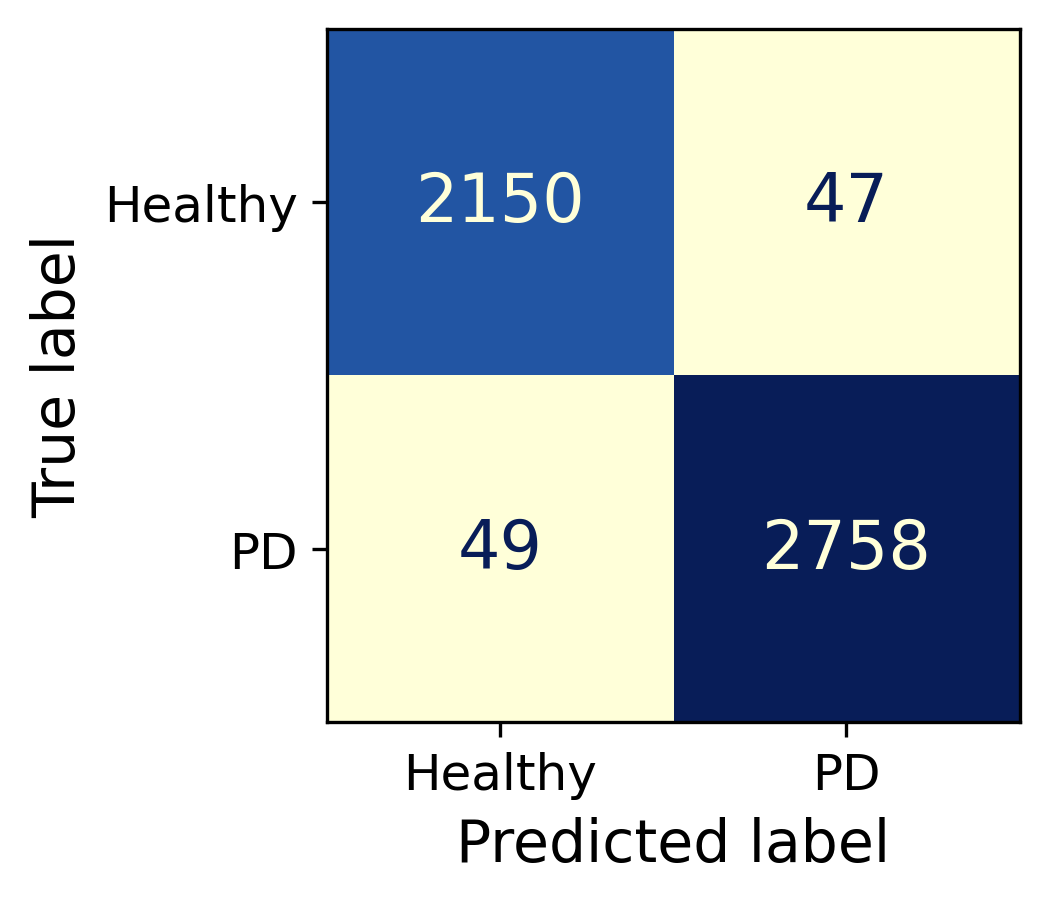

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
correct = 0
for data, target in test_loader:
        # output = A(inputs) # Feed Network
        # print(output)
        # print(output.shape)

        # output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        # y_pred.extend(output) # Save Prediction
        
        # target = target.data.cpu().numpy()
        # target = (target[:, 1] > 0.5).astype("int32")
        # y_true.extend(target) # Save Trut

        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        target=target.float()

        # forward propagation on the data
        prediction = neural_net(data)

        # compute the number of correct predictions en sortie)
        _, pred_classes = torch.max(prediction, dim=1)
        _, target_classes = torch.max(target, dim=1)
        y_true.extend(target_classes)
        y_pred.extend(pred_classes)
        correct += int(pred_classes.eq(target_classes).sum().item())
        
# constant for classes
classes = ('PD','Healthy')

#print(type(target))

# Build confusion matrix
cf_matrix = confusion_matrix(y_pred, y_true)
print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Healthy','PD'])
cmd.plot(cmap = 'YlGnBu', colorbar = False)

#cmd.plot(cmap = 'YlGnBu', colorbar = False)

fig = cmd.ax_.get_figure()

fig.set_figwidth(3)
fig.set_figheight(3)
plt.rcParams["figure.dpi"] = 300
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=14)
# Set the axes labels font size
plt.rc('axes', labelsize=14)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)
#plt.savefig(dpi = 300, fname = 'astro_LR.png')
#sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

####Create plots of the learning curves.

In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
#Plot
x = list(range(len(train_losses)))
ax = plt.subplot(111)

# #Feb 5 new: set ticks, axis and spins black
# ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
# ax.spines['bottom'].set_color('black')

# ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_losses, 'b', label="Train")
plt.plot(x, val_losses, 'r', label="Validation")
plt.xlabel('epoch', size=16)
plt.ylabel('Cross-entropy loss', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

f = plt.figure()
# f.set_figwidth(4)
# f.set_figheight(4)

# leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
# leg.get_frame().set_alpha(0.99)

#Add a legend
pos = ax.get_position()
#ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
# ax.legend(loc='lower center', bbox_to_anchor=(1.33, 0.91), frameon = False, fontsize = 16)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), frameon = True, fontsize = 16)

plt.savefig("train_losses.png", transparent = True, bbox_inches='tight')

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)

# #Feb 5 new: set ticks, axis and spins black
# ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
# ax.spines['bottom'].set_color('black')

# ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_accuracies, 'b', label="Train")
plt.plot(x, val_accuracies, 'r', label="Validation")
plt.xlabel('epoch', size = 16)
plt.ylabel('Accuracy', size = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

f = plt.figure()

# Add a legend
pos = ax.get_position()
# ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
# ax.legend(loc='center right', bbox_to_anchor=(1.33, 0.91), facecolor = 'white')

plt.rcParams["figure.dpi"] = 500
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), frameon = True, fontsize = 16)
plt.savefig("train_accuracies.png", transparent = True, bbox_inches='tight')

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)

#Feb 5 new: set ticks, axis and spins black
ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('black')

ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_accuracies, 'b', label="Train")
plt.plot(x, val_accuracies, 'r', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

# Add a legend
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.33, 0.91), facecolor = 'white')

plt.rcParams["figure.dpi"] = 500

plt.rc('font', size=14)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)

plt.savefig("train_accuracies.png", transparent = True, bbox_inches='tight')